# Phase 4: Optimisation analysis of the logistic infrastructure

##### Table of content:
1. [Descriptive analysis](#part1)
2. [Estimated delivery time](#part2)
3. [Late delivery prediction (Classification)](#part3)
4. [Conclusion](#part4)

## <font color='blue'>Introduction</font>

Customers does not only look for online shopping with the best variety of products and best user experience. They are also demanding fast delivery without delays. Throughout the project we have analyzed various hypotheses that might help Olist optimize business critical KPI's that focus on the cutomer, the sellers, and the process of purchasing products, keeping customers, getting the best sellers on the platform, etc. In this last part, we will analyze the potential of maximizing the latent but critical value in the process of delivering the products. Estimation of delivery is both important when the customer is choosing between products and potentially holding delivery date as a decisive factor, and when delivering the physical product to the customer by connecting logistics providers and various sellers. These operational tasks, which is not directly handled by Olist, are critical to Olist's image and how satisfied customers are after shopping on Olist. 

The goal with the following analysis is threefold. First, we are assessing whether there exist a problem in terms of delivering the products to the customers. The delivery performance is analyzed by looking at historical data and how many delays Olist has had thoughout the dataset. Second, we will optimize Olist's estimate of delivery resulting in better decision-making for the customers and higher convenience throughout the later part of the shopping experience. Lastly, we are going to predict whether an order will be delivered in time or too late by classifying an order upon purchase. 

## <font color='blue'>KPI's</font>


Operational excellence is at the hart of an Ecommerce if customer satisfaction is a top priority. Optimization across both estimated delivery and potential delivery delay is helping Olist on several important KPI's. We can potentially increase Customer Acquisition and Customer Retention rates if Olist are able to proof a trackrecord of fast and exact delivery. Furthermore, if we are able to predict whether a package is late or not and use a set of tools to counteract a potential late delivery, the number of Late Deliveries is a KPI in itself that we would want to optimize. 

## <font color='blue'>Setup 1</font>: Load Libraries

In [1]:
import numpy as np
import pandas as pd
import sys, os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from math import sin, cos, sqrt, atan2, radians
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import backend as K
%matplotlib inline
import geopandas as gpd
import pysal as ps
from pysal.viz.splot import mapping as maps
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set()
sns.color_palette("Paired")
plt.rcParams['figure.figsize'] = (15.0, 8.0)
plt.style.use('ggplot')

Using TensorFlow backend.
/anaconda3/lib/python3.7/site-packages/pysal/explore/segregation/network/network.py:16: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  "You need pandana and urbanaccess to work with segregation's network module\n"
/anaconda3/lib/python3.7/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


## <font color='blue'>Setup 2</font>: Load data

The workbook will focus on the delivery and Geospatial part of the OLIST dataset. Therefore, the following datasets are loaded and joined:

- olist_customers_dataset
- olist_order_items_dataset
- olist_customers_dataset
- olist_sellers_dataset
- olist_geolocation_dataset

These are joined by the left-join operation and dataformat is set. 

In [2]:
def load_table(tablename):
    """ Defining the current directory and path to where data are located. Joining path to
    data folder and table name in order to read the table into a Pandas DataFrame"""
    file_path = os.path.join ('../data/') 
    df = os.path.join(file_path, tablename) 
    df = pd.read_csv(df, sep=',', encoding="latin1") 
    return df

In [3]:
# Reading the olist_orders table
orders = load_table('olist_orders_dataset.csv')
order_items = load_table('olist_order_items_dataset.csv')
customers = load_table('olist_customers_dataset.csv')
customers.columns = ['customer_id','customer_unique_id','geolocation_zip_code_prefix',
                     'customer_city','customer_state']
sellers = load_table('olist_sellers_dataset.csv')
sellers.columns = ['seller_id','geolocation_zip_code_prefix',
                     'seller_city','seller_state']
geo = load_table('olist_geolocation_dataset.csv')

We want to investigate orders and their individual properties. An order can both have multiple products and multiple sellers. If an order has multiple sellers we the order as a unique order for each seller. In the following cell we first make sure to group orders by their order id, product id, seller id and respectively properties. Though we make sure only to keep the max of the quantity id. Thus, we can extract the total order value for each product id represented in a given order by multiplying the quantity and price. Now we can get rid of the product and group the data by the order id and seller id, their respective features and sum the price for each seller represented in the order.

In [4]:
order_items_filt = order_items.groupby(['order_id', 'product_id','seller_id','shipping_limit_date','freight_value','price'])['order_item_id'].agg({"quantity":"max"}).reset_index()
order_items_filt['order_price'] = order_items_filt['price']*order_items_filt['quantity']
order_items_filt = order_items_filt.groupby(['order_id','seller_id','shipping_limit_date','freight_value','quantity'])['order_price'].agg('sum').reset_index()

In [5]:
# Removing outliers based on coordinates
#Brazils most Northern spot is at 5 deg 16′ 27.8″ N latitude.;
geo = geo[geo.geolocation_lat <= 5.27438888]
#it’s most Western spot is at 73 deg, 58′ 58.19″W Long.
geo = geo[geo.geolocation_lng >= -73.98283055]
#It’s most southern spot is at 33 deg, 45′ 04.21″ S Latitude.
geo = geo[geo.geolocation_lat >= -33.75116944]
#It’s most Eastern spot is 34 deg, 47′ 35.33″ W Long.
geo = geo[geo.geolocation_lng <=  -34.79314722]
#source: https://www.kaggle.com/andresionek/geospatial-analysis-of-brazilian-e-commerce

### Merge datasets

First, we are taking a look at the geolocations 

In [6]:
geo.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


Since the zip-codes has several different geolocations very close to each other, we will aggregate those different locations into a mean location. Even though it is not geographically correct to take the mean of the longitude and latitude, especially is the distances are large, we assume that it is coorect in this example. Argualy, it does not make a difference in this example since the distances are very close. 

In [7]:
geo = geo.groupby('geolocation_zip_code_prefix')['geolocation_lat','geolocation_lng'].agg('mean').reset_index()

Now that each zipcode has a unique geolocations, they are joined (left) on the customer and sellers dataset

In [8]:
# Merging geo location to sellers and customers dataset
customers_geo = customers.merge(geo, on = "geolocation_zip_code_prefix", how = "left")
customers_geo = customers_geo[['customer_id', 'geolocation_lat','geolocation_lng']]
customers_geo.columns = ['customer_id', 'customer_lat','customer_lon']

sellers_geo = sellers.merge(geo, on = "geolocation_zip_code_prefix", how = "left")
sellers_geo = sellers_geo[['seller_id', 'geolocation_lat','geolocation_lng']]
sellers_geo.columns = ['seller_id', 'seller_lat','seller_lon']

Each sellers geo location is then joined with the orders dataset.

In [9]:
# Merging geo location to orders dataset
order_items_all = order_items_filt.merge(sellers_geo, on='seller_id', how='left')

orders_all = orders.merge(customers_geo, on='customer_id', how='left')
orders_all = orders_all.merge(order_items_all, on='order_id',how='left')

orders_all = orders_all[['order_id','order_status', 'customer_id', 'seller_id', 'order_purchase_timestamp',
                         'order_approved_at','order_delivered_carrier_date','shipping_limit_date',
                         'order_delivered_customer_date','order_estimated_delivery_date','order_price',
                         'quantity','freight_value','customer_lat','customer_lon','seller_lat', 'seller_lon']]

In this analysis only the orders with an order status of "delivered" are considered. As seen from the list below several different order statuses exist. 

In [10]:
print(list(set(orders_all.order_status)))
# Filter all orders that has been delivered
delivered_orders = orders_all[orders_all['order_status']=='delivered']
delivered_orders = delivered_orders.drop('order_status', axis=1)

['canceled', 'approved', 'invoiced', 'processing', 'shipped', 'created', 'unavailable', 'delivered']


All the timestamp columns are changed to pandas datetime format

In [11]:
delivered_orders.order_purchase_timestamp = pd.to_datetime(delivered_orders.order_purchase_timestamp)
delivered_orders.order_approved_at = pd.to_datetime(delivered_orders.order_approved_at)
delivered_orders.shipping_limit_date = pd.to_datetime(delivered_orders.shipping_limit_date)
delivered_orders.order_delivered_carrier_date = pd.to_datetime(delivered_orders.order_delivered_carrier_date)
delivered_orders.order_estimated_delivery_date = pd.to_datetime(delivered_orders.order_estimated_delivery_date)
delivered_orders.order_delivered_customer_date = pd.to_datetime(delivered_orders.order_delivered_customer_date)

First the number of missing values (NaN) are counted for each column and then they are removed

In [12]:
def count_missing_values(df):
    missing = df.isna()
    num_missing = pd.DataFrame(missing.sum(),columns=['Number'])
    num_missing['Percentage'] = round(num_missing / len(df),4)
    print(num_missing)
          
count_missing_values(delivered_orders)
delivered_orders = delivered_orders.dropna()

                               Number  Percentage
order_id                            0      0.0000
customer_id                         0      0.0000
seller_id                           0      0.0000
order_purchase_timestamp            0      0.0000
order_approved_at                  14      0.0001
order_delivered_carrier_date        2      0.0000
shipping_limit_date                 0      0.0000
order_delivered_customer_date       8      0.0001
order_estimated_delivery_date       0      0.0000
order_price                         0      0.0000
quantity                            0      0.0000
freight_value                       0      0.0000
customer_lat                      274      0.0027
customer_lon                      274      0.0027
seller_lat                        222      0.0022
seller_lon                        222      0.0022


## <font color='blue'>Part 1</font>: Descriptive analysis
<a id=part1></a>


When a purchase is approved, the seller is given a `shipping_limit_date` telling when they have to pass on the product to a third party logistic company. A customer is given an `order_estimated_delivery_date`.

In the following we are trying to assess how many order are delivered later than estimated and why this might happen. We are considering purchase date, shipping limit date, order estimated delivery data and actual delivery date as relevant columns in regards to analyzing delivery times. 

In [13]:
#Calculating difference between order_estimated_delivery_date and the actual order_delivered_customer_date
delivered_orders['delivery_difference'] = delivered_orders.order_estimated_delivery_date - delivered_orders.order_delivered_customer_date
delivered_orders['delivery_difference'] = delivered_orders['delivery_difference'].dt.days

In [14]:
delivered_orders['delivery_difference'].describe()

count    99678.000000
mean        10.987720
std         10.208975
min       -189.000000
25%          6.000000
50%         12.000000
75%         16.000000
max        146.000000
Name: delivery_difference, dtype: float64

The customer recieves the product 10,98 days ahead of the estimated delivery day on average.

In [15]:
print("Number of orders delivered later than the estimated delivery data:",len(delivered_orders[delivered_orders['delivery_difference']<0]))

Number of orders delivered later than the estimated delivery data: 7943


Meaning ~8% of the orders was delivered later than the estimated delivery date.

In the olist_orders_dataset we have 95,978 unique orders and 99,678 total orders, i.e. ~4% procent of the orders includes multiple sellers. Thus, one product from one seller can be delivered on time, while the other are late.

We want to see whether we are to blame the sellers or the logistic firm for the orders delivered late. Therefore, we plot all delivered orders with the shipping difference as the x-axis and delivery difference as the y-axis.

- If X > 0 the order was delivered on time. 
- If X < 0 and Y > 0 the logistic firm is the one to blame
- If X < 0 and Y >= X then the seller is the one to blame
- If X < 0 and Y < 0 the both the seller and the logistic firm is to blame

Before plotting the delivery times, we need to calculate the difference between the `shipping_limit_date` and `order_delivered_carrier_date`. 

In [16]:
#Calculating difference between shipping_limit_date and order_delivered_carrier_date
delivered_orders['shipping_difference'] = delivered_orders.shipping_limit_date - delivered_orders.order_delivered_carrier_date
delivered_orders['shipping_difference'] = delivered_orders['shipping_difference'].dt.days

In [17]:
# Removing outlier
delivered_orders = delivered_orders.drop(89664)
delivered_orders['shipping_difference'].describe()

count    99677.000000
mean         2.832569
std          3.747486
min       -117.000000
25%          1.000000
50%          3.000000
75%          5.000000
max        175.000000
Name: shipping_difference, dtype: float64

As seen in the above table, a product is passed on to the logistic firm 2.8 days ahead on average, which indicates that sellers are proably not the error. However, we will se that below. 

In [18]:
def plot_late_order(df):
    X = [x for x in df.delivery_difference]
    X = np.array(X)
    Y = [y for y in df.shipping_difference]
    Y = np.array(Y)

    col = np.where((X<0) & (Y<0) & (Y<X),'red',
            np.where((X<0) & (Y<0) & (Y>=X),'yellow',
                np.where((X<0) & (Y>=0),'orange','grey')))
    
    fig, ax = plt.subplots()
    ax.scatter(X, Y, c=col)
    ax.set_xlabel('Delivery difference')
    ax.set_ylabel('Shipping difference')
    ax.set_title('Orders')
    ax.axhline(linewidth=1, color='black')
    ax.axvline(linewidth=1, color='black')
    plt.show()

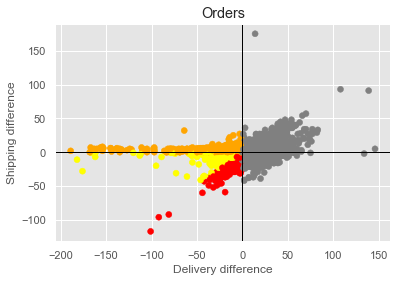

In [19]:
plot_late_order(delivered_orders)

1. **Grey points**: order was delivered on time
2. **Orange points**: order was late because of the logistic firm
3. **Yellow points**: order was late because of the seller
4. **Red points**: order was late because of both the seller and the logistic firm

Counting the number of points in each category to find the distribution of the different causes of delay. 

In [20]:
X = [x for x in delivered_orders.delivery_difference]
Y = [y for y in delivered_orders.shipping_difference]

grey_points = [i for i, x in enumerate(X) if (X[i]>=0)]
orange_points = [i for i, x in enumerate(X) if (X[i]<0) and (Y[i]>=0)]
yellow_points = [i for i, x in enumerate(X) if (X[i]<0) and (Y[i]<0) and (Y[i]>=X[i])]
red_points = [i for i, x in enumerate(X) if (X[i]<0) and (Y[i]<0) and (Y[i]<X[i])]

In [21]:
print(" %5.2f pct. of the orders was delivered on time" %((len(grey_points)/len(X))*100))
print(" %5.2f pct. of the orders was delivered late because of the logistic firm" %((len(orange_points)/len(X))*100))
print(" %5.2f pct. of the orders was delivered late because of the seller" %((len(yellow_points)/len(X))*100))
print(" %5.2f pct. of the orders was delivered late because of both the seller and logistic firm" %((len(red_points)/len(X))*100))

 92.03 pct. of the orders was delivered on time
  5.78 pct. of the orders was delivered late because of the logistic firm
  1.34 pct. of the orders was delivered late because of the seller
  0.85 pct. of the orders was delivered late because of both the seller and logistic firm


The data clearly suggests that the main problem with the late orders is the logistic provider not providing the service needed to deliver on time. This might already suggest improvements, such as better logisitcs deals and potentially contractual agreements about a minimum threshold for late deliveries. 

We would like to assess whether customers in specific regions of Brazil is more likely to recieve their packages late. In order to investigate that, we are using the customers longitude and latitude and information about whether they recieved their package late or not. 

In [22]:
delivered_orders['late'] = (delivered_orders.order_estimated_delivery_date > delivered_orders.order_delivered_customer_date).astype(int)

In [23]:
# Defining a dataframe for the plot and the settings for the plot
df_plot = delivered_orders.groupby(['customer_lat','customer_lon']).agg({'late':'mean', 'customer_lat':'count'})['late'].reset_index()
bins = [-1, .85, .95, 1]
names = [0,1,2]
df_plot['cat'] = pd.cut(df_plot['late'], bins, labels=names)

In [24]:
# Define color dictionary
color_map = {0:"#ff0000", 1:"#fef800", 2:"#398800"}

In [25]:
df_plot = df_plot[['customer_lat','customer_lon','cat']]
gdf = gpd.GeoDataFrame(
    df_plot, geometry=gpd.points_from_xy(df_plot.customer_lon, df_plot.customer_lat))

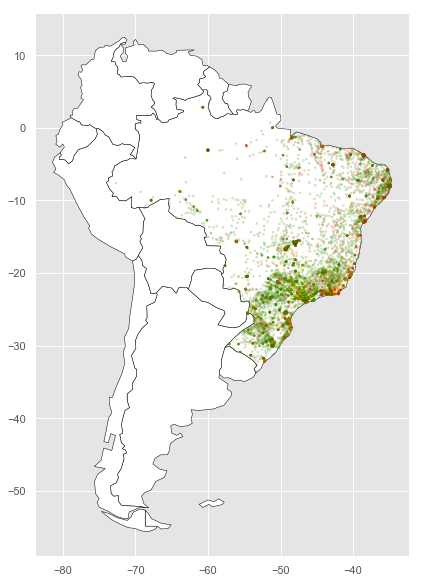

In [26]:
#Plotting the customers that recieved package in time, just around the eatimated and too late. 
plt.rcParams['figure.figsize'] = [10, 10]
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#world = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

# restrict to South America.
#ax1 = world[world.continent == 'South America'].plot(
ax1 = world[world.continent == 'South America'].plot(
    color='white', edgecolor='black')

colors = [color_map[x] for x in df_plot['cat']]
gdf.plot(ax=ax1, color=colors, alpha=0.2, markersize=4)

Earlier we found that around 8% of all packages are delivered late. The colors are indicating whether the given area is above, around or below this mean of recieving the packages late:
- Green: density of packages delivered on time is below the global mean
- Yellow: density of packages delivered on time is around the global mean (+/- 5%) 
- Red: density of packages delivered on time is abbove the global mean

It is not immediately possible to detect any pattern in the geograohic data, many of the areas has very few datapoints which makes it difficult to assess patterns. However, In Rio de Janeiro a the red points seems to dominate, this could indicate that Olist have difficulties delivering wihtin the city. If Olist continues to collect data and continouesly update the geographic dashboard, there might be valueable insights in the future. 

## <font color='blue'>Part 2</font>: Estimated delivery time
<a id=part2></a>

In order to improve the estimated delivery time, we are investigating whether there exist an actual problem with the current estimate that Olist are providing the customer at the purchase moment. Before looking into the problem, we are creating some features necessary for the analysis. 

### 2.1 Creating features

We can create some features relevant for the problem such as:
- actual delivery date
- distance from seller to customer

Apart from that, we have features from the original datasets provided by Olist.

In [27]:
#Calculating the actual delivery time
delivered_orders['actual'] = delivered_orders.order_delivered_customer_date - delivered_orders.order_purchase_timestamp
delivered_orders['actual'] = delivered_orders['actual'].dt.days

In [28]:
#Displaying information about the actual delivery times on the products
delivered_orders.actual.describe()

count    99677.000000
mean        12.021128
std          9.530163
min          0.000000
25%          6.000000
50%         10.000000
75%         15.000000
max        209.000000
Name: actual, dtype: float64

In [29]:
#Creating a function for calculating distances from seller to customer. 
def geoDistance(lat0, lon0, lat1, lon1):
    # Approx. radius of earth (km)
    R = 6373.0 
    # Convert to radians
    lat0, lon0 = radians(lat0), radians(lon0)
    lat1, lon1 = radians(lat1), radians(lon1)
    
    # Getting differences
    dlon, dlat = lon1 - lon0, lat1 - lat0
    
    # Use haversine formula
    a = sin(dlat / 2)**2 + cos(lat0) * cos(lat1) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

In [30]:
#Calling the function to create a distance measure for all orders
delivered_orders['Distance'] = delivered_orders.apply(lambda row:\
    geoDistance(row['customer_lat'], row['customer_lon'], row['seller_lat'], row['seller_lon']), axis=1)

In [31]:
#Calculating the estimated delivery in days
delivered_orders["estimated_delivery"] = (delivered_orders.order_estimated_delivery_date-delivered_orders.\
                                          order_purchase_timestamp).dt.total_seconds() / (24 * 60 * 60)

In [32]:
#Defining the relevant features for the problem
features = ['order_price','quantity','freight_value','customer_lat',
           'customer_lon','seller_lat','seller_lon','Distance','estimated_delivery']
target = ['actual']

X = np.array(delivered_orders[features])
y = np.array(delivered_orders['actual'])
split_test_size = 0.30

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = split_test_size, random_state=42)

The distribution of the `actual delivery` feature created can be plotted with the distribution of the `estimated delivery` feature to get an idea about Olist's estimated deliveries versus their actual deliveries. 

In [33]:
#Creating variables for both actual and estimated deliveries
actual_delivery = delivered_orders.actual
estimated_delivery = delivered_orders.estimated_delivery

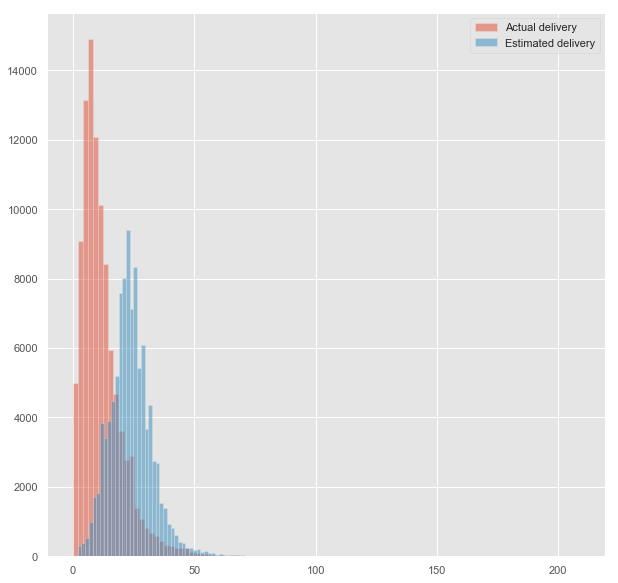

In [34]:
#Plotting actual delivery times and estimated delivery times
plt.hist(actual_delivery, bins= 100, alpha=0.5, label='Actual delivery')
plt.hist(estimated_delivery, bins= 100, alpha=0.5, label='Estimated delivery')
plt.legend(loc='upper right')
plt.show()

As can be seen from the plot above, Olist are systematically overestimating the delivery dates, which might give customers a motivation for shopping through another eCommerce, if they are estimating a faster delivery. 
Therefore, we want to enable a correct and much better estimated delivery time, so that the customer gets more correct information about the faster delivery of their products. 

### 2.2 Establish baseline

The metrics that we are going to use for this task is both the mean absolute error (MAE) and the mean squared error (MSE). The reason for using these measures is that MAE gives an abosulte value which is easy to relate to. In our case, an error of 2 days is twice as large as an error of 1 day which makes it easy to relate to. On the other hand, MSE is good while it penalizes large deviations. This is relevant in our case, as we do not want to underestimate the delivery time while inconvenient for the customer. 

In [35]:
def metrics(y, yhat):
    """ Defining the metrics to evaluate model performance. Using mean absolute error
    and mean squared error from the sklearn library. """
    
    mae = mean_absolute_error(y, yhat)
    mse = mean_squared_error(y, yhat)
    
    print('Error in estimate for actual delivery date:')
    print('Mean absolute error:', round(mae, 2), 'days.')
    print('Mean squared error:', round(mse, 2), 'days.')

##### Baseline: how much is Olist wrong at the current state

In this cell, we are looking at the estimated time of delivery that Olist gives the customer upon purchase. We are then measuring what the error is on this estimate given to the customer by looking at the actual delivery date. 

In [36]:
#Defining an array consisting of the estimated delivery times and the actual delivery times
Y_estimate = X_test[:,-1]
#Calculating error
metrics(y_test, Y_estimate)

Error in estimate for actual delivery date:
Mean absolute error: 13.25 days.
Mean squared error: 245.81 days.


From assessing the error in delivery estimates on the test set we get a Mean Squared Error (MSE) is 245.8 days and the MAE is 13.25 days, which will be the baseline going forward. The hypothesis is, that are able to make more accurate models to predict delivery estimates, which can be used to increase business value. 

The last feature in the test and trining set was only included for the purpose of the above calculation and will this be removed.

In [37]:
#Removing the last column in x_train and x_test
X_test = X_test[:,:-1]
X_train = X_train[:,:-1]

##### Mean prediction

Predicting the average delivery time for all the orders. In this cell, we will look at how well a baseline model does, if we predict all the coming delivery times, to be the same as the average of all delivery times from our training set. This can act as a baseline, to see if the measure is actually a better prediction that the estimate Olist are currently able to provide.

In [38]:
#Creating a baseline predicting the average delivery time
Y_pred_baseline = y_train
Y_pred_baseline = np.mean(Y_pred_baseline)
Y_pred_baseline = [Y_pred_baseline] * len(y_test)
#Calculating error
metrics(y_test, Y_pred_baseline)

Error in estimate for actual delivery date:
Mean absolute error: 6.39 days.
Mean squared error: 93.39 days.


The mean prediction model shows, that there is a potential to be significantly more correct in estimating the delivery times by estimating the delivery time as the average actual delivery time in the training set. This poses the question, if we can further improve the estimate from using more advanced models, which rely on some of the features that we have available when a customer places an order. 

##### Linear regression model

At first, we will use a linear regression model to see if we can beat the baseline model. Furthermore, the linear regression model might indicate which features that has an impact on the estimated delivery time. 

In [39]:
#Normalizing features
X_train = preprocessing.normalize(X_train)
X_test = preprocessing.normalize(X_test)

In [40]:
#Defining and fitting a linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train);

In [41]:
#Predicting the estimated delivery times and calculating the error
predictions = lr.predict(X_test)

metrics(y_test, predictions)

Error in estimate for actual delivery date:
Mean absolute error: 5.66 days.
Mean squared error: 80.18 days.


In [42]:
for i in range(len(lr.coef_)):
    print("Feature:","'",features[i],"'", "has the following impact on the estimated delivery: ", lr.coef_[i])

Feature: ' order_price ' has the following impact on the estimated delivery:  -7.911069869829461
Feature: ' quantity ' has the following impact on the estimated delivery:  -28.291778977958355
Feature: ' freight_value ' has the following impact on the estimated delivery:  18.649379773569493
Feature: ' customer_lat ' has the following impact on the estimated delivery:  62.12760507542602
Feature: ' customer_lon ' has the following impact on the estimated delivery:  63.23905866263827
Feature: ' seller_lat ' has the following impact on the estimated delivery:  -62.601335132490355
Feature: ' seller_lon ' has the following impact on the estimated delivery:  -35.39820853269129
Feature: ' Distance ' has the following impact on the estimated delivery:  -4.754385526559439


We see that this model performs slightly better than the mean prediction and significantly better than the baseline model. Furthermore, we get an idea about which features play an important role for the eatimate of the delivery. Given that we are using MAE as one of the metrics, we are able conclude an improvement of almost a day more in precision of our estimate. 

Here price and distance is the least important features, while seller latitude and customer latitude is the most important featuers. This is one of the main advantages of a linear regression model, namely, that we are able to know why some orders are predicted to have high and low estimated delivery times given the model coefficients. 

##### Feed Forward Neural Network

Linar regression turned out to be quite successfull when estimating delivery times compared to the baseline. This is a verification of the hypothesis proposed about whether it is possible to catch a signal in the current data, and also demonstrates that we can provide business value using prediction models in this problem. To further assess if we can obtain even lower error rates we are using a Feed Forward Neural Network (FFNN) to try and make even better predictions about estimated delivery times. 

The FFNN used for this task has the following architechture:
- Input size 8
- Two hidden layers:
    - first layer has 20 neurons
    - second layer has 50 neurons
- Applying ReLu activation function in both layers
- Using a dropout rate of 0.5 between each layer
- Output size 1 (the prediction)

We are furthermore using a batch size of 64 and training the network for 15 epochs. These settings has been tested over several runs, and hence the hyperparameters are chosen from the performance yield. 

In [43]:
#Defining input size
input_ = X_train.shape[1]

#Defining model
model = Sequential()
model.add(Dense(20, input_dim=input_, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(50, input_dim=20, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(1, activation='linear'))
#Specifying what type of loss function and optimizer to use:
model.compile(loss=["mean_absolute_error"], optimizer='adam')

#model.fit(X_train, y_train, epochs=10, batch_size=16)
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test,y_test))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 69773 samples, validate on 29904 samples
Epoch 1/10
69773/69773 [==============================] - 7s 103us/step - loss: 6.3239 - val_loss: 5.3530
Epoch 2/10
69773/69773 [==============================] - 6s 82us/step - loss: 5.5478 - val_loss: 5.2949
Epoch 3/10
69773/69773 [==============================] - 6s 83us/step - loss: 5.4592 - val_loss: 5.2586
Epoch 4/10
69773/69773 [==============================] - 5s 78us/step - loss: 5.4198 - val_loss: 5.2500
Epoch 5/10
69773/69773 [==============================] - 5s 77us/step - loss: 5.3917 - val_loss: 5.2482
Epoch 6/10
69773/69773 [==============================] - 6s 81us/step - loss: 5.3721 - val_loss: 5.2376
Epoch 7/10
69773/69773 [==============================] - 5s 77us/step - loss: 5.3489 - val_loss: 5.2287
Epoch 8/10
69773/69773 [==============================] - 5s 77us/step - loss: 5.3289 - val_lo

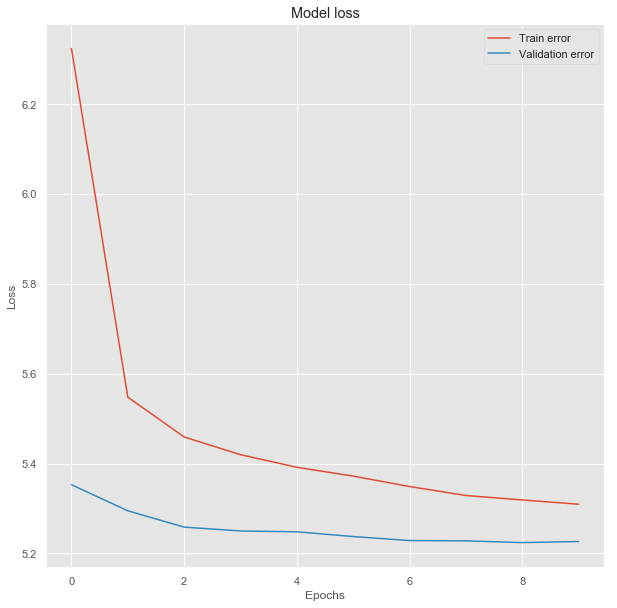

In [44]:
#Plotting the train and validation error:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train error', 'Validation error'], loc='upper right')
plt.show()

In [45]:
print("MAE of the FFNN model after the 10th epoch is:", history.history["val_loss"][-1])

MAE of the FFNN model after the 10th epoch is: 5.226578566274138


In [46]:
#Predicting the loss
y_pred = model.predict(X_test)

In [47]:
#Assessing the error
metrics(y_test, y_pred)

Error in estimate for actual delivery date:
Mean absolute error: 5.23 days.
Mean squared error: 82.4 days.


As seen in the training history of the FFNN the model learns through the first ~10 epochs and ends up with a MAE validation error (which is performed on the test set) of 5.23. The learning process is also plotted above, and as we see there is no overfitting, since the validation error does not spike at any point. Dropout has the function of trying to prevent overfitting, which suggests a succesfull job in this regard. Note, however, that it might seem strange that the validation error is systematically below the training error, which seems counter intuitive. Online documentation suggest, that this is due to the dropout only being applied during training and not during prediction, which might enable the model to perform slightly better on test than train. 

Overall, the best model is the FFNN, which yields a slightly better estimate than the linear regression. There are pros and cons for using both models, especially in terms of explainability. The most important take is that we are able to confirm the hypothesis of being able to optimize delivery estimates. 

## <font color='blue'>Part 3</font>: Late delivery prediction (Classification)
<a id=part3></a>

This last analysis will seek to predict whether a delivery will be late or not. An online retailer platform like Olist can benefit from this analysis in several different ways: First, simply knowing which factors affect the delivery of orders is useful. Secondly, having this model deployed and in production, Olist would be able to warn sellers and customers when a order was predicted to be delivered late. 

This model will use logistic regression to perfrom the binary classification, where the the target variable $y$ is defined as: 1 if the order was delivered on time and 0 if it was late. First, the target variable `late` is created  by comparing the variables `order_estimated_delivery_date` and `order_delivered_customer_date`:

In [48]:
df = delivered_orders
df['late'] = (delivered_orders.order_estimated_delivery_date > delivered_orders.order_delivered_customer_date).astype(int)

Secondly, the variable/features are selected, standardized and split into train and test 

In [49]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import numpy as np

X = df[['quantity','order_price','freight_value','Distance','customer_lat','customer_lon','seller_lat', 'seller_lon']]
y = df['late'].values

X = preprocessing.MinMaxScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [50]:
df['late'].value_counts()

1    91734
0     7943
Name: late, dtype: int64

The data is clearly imbalanced, and because of this the F1-measure will be used to score the model.
First a dummy classifier is fitted to the data:

In [51]:
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
y_pred = dummy_clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2619
           1       0.92      1.00      0.96     30275

    accuracy                           0.92     32894
   macro avg       0.46      0.50      0.48     32894
weighted avg       0.85      0.92      0.88     32894



It is clear that a high accuracy and high weighted avg F1 are achieved with even only a dummy classifier. However this dummy classifier only predicts the most frequent class 1 (delivered on-time). In this case we mostly interested in accuracy in class 0 i.e. predicting when a order is late. This means that we want to be aware of the False Negatives errors.  

the problem of imbalance is dealt with by setting the argument `class_weight` to 'balanced'. This penalizes minority class mistakes by an amount proportional to how much under-represented it is.

Gridsearch and Cross-validation is used to tune hyperparameters of the logistic regression model:

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

grid={"C":np.logspace(-3,3,7), "penalty":["none","l2"]} # l1 lasso l2 ridge

clf = LogisticRegression(random_state=0, solver='lbfgs',
                          multi_class='multinomial', class_weight='balanced')

logreg_cv=GridSearchCV(clf, grid, cv=10)
logreg_cv.fit(X_train, y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.001, 'penalty': 'l2'}
accuracy : 0.701376098707755


The result of the gridsearch shows that a Regularization strength (C) of 0.001 and a l2-norm for penalization.

In [53]:
logreg2=LogisticRegression(C=0.001,penalty="l2", solver='lbfgs',
                          multi_class='multinomial', class_weight='balanced')
logreg2.fit(X_train, y_train)

y_pred = logreg2.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.11      0.40      0.17      2619
           1       0.93      0.73      0.82     30275

    accuracy                           0.70     32894
   macro avg       0.52      0.56      0.50     32894
weighted avg       0.87      0.70      0.77     32894



In terms of weighted avg F1 (0.77%) the model is worse than the dummy classifier. However the F1-score of class 0 is 17% (better than dummy). With this model, Olist would be able to predict only a small amount of the late deliveries. Given the very unbalanced data this was expected.

In [54]:
name = ['quantity','order_price','freight_value','Distance','customer_lat','customer_lon','seller_lat', 'seller_lon']
coef = logreg2.coef_[0]

We sort the coefficients produced by the model:

In [55]:
sorted((zip(coef,name)), key=lambda x: np.abs(x[0]), reverse = True)

[(-0.27765383755774964, 'customer_lon'),
 (-0.2649618260325054, 'Distance'),
 (-0.1131999380801491, 'customer_lat'),
 (-0.09686063119387225, 'seller_lat'),
 (-0.05892331106645346, 'freight_value'),
 (0.02438032015589164, 'quantity'),
 (-0.009832480230176056, 'order_price'),
 (-0.003876767952622549, 'seller_lon')]

From the coefficients we see that Customer longitude ('customer_lon') and distance between seller and customer ('Distance') has the biggest impact. Since a prediction of 0 means "late" and a prediction of 1 menas "on time", both of the coefficients affects the prediction to go towards a "late" prediction. This makes sense intuitively while the longitude and distance are both coefficients indicating transportation over large distances. 
The only coefficient having a positive impact on a "on time" prediction is the quantity which might indicate that larger orders are prioritized, although it should be stated that it is of little importance to the model.

If the model has positive impact on business critical KPI's, Olist could consider start gathering the following features that could prove useful for the model: 
- Weather forcast data
- Historical weather data
- Real distance between seller and customer (on roads)
- Seller track record (in terms of number of previously late deliveries. 
- Seller reviews (average)
- Previously late delivery

## <font color='blue'>Conclusion</font>
<a id=part4></a>

The short descriptive analysis and the two predictive analyses tells us the following:

- 7.97% out of the total number of orders are delivered late. Two-thirds of those orders delivered late is caused by the logistic firm. Therefore, Olist need to optimise this part of the order-to-delivery process by figuring out what to do with the logistic firms.
- The Mean Absolute Error on all delivery times is 13.25 days while if predicting the delivery time to be the global mean we get an error of 6.39 days. This means that we can improve the baseline subbstantially by just predicting the mean.
- To approve the estimated delivery time, we have experimented with a few different prediction models. The linear regression model performs best being only 5.66 days off, which is slightly better than the mean prediction.
- To see if it is possible to classify whether an order will run late before it happens, we have implemented a logistic regression model. The model performed a weighted average f1-score on 0.77, which is worse than a dummy classifier classifier the most frequent class. However, the logistic regression is able to flag a small amount of orders running late correctly.
- In order to analyse the most important features explaining why an order is running late, the logistic regression produces interpretable coefficients. These tells us that the customer geo-location and the distance between a seller and a customer explains orders delivered late the most.